This is part 1 of my analysis of Benjamin Pavard's half volley goal against Argentina in the quarter finals of the 2018 FIFA World Cup. If you are unaware of the goal in question, have a look at the link below:
https://www.youtube.com/watch?v=Ov39iGAgEn4

This part of the analysis will give a brief introduction to event data in football, and then provide an analysis of the shots and expected goals (xG) in the match, tactics and lineups, and lastly possession patterns.

In [1]:
import polars as pl 
from statsbombpy import sb 

import mplsoccer as mpl

import sys
sys.path.append("..") 
sys.dont_write_bytecode = True

import warnings
warnings.filterwarnings("ignore")

In [2]:
from utils.statics import figsize, PITCH_X, PITCH_Y, xg_scale_factor
from utils.utils import (invert_orientation, invert_one_orientation, add_legend, plot_player_positions, plot_pitch_with_shots, plot_gmm_components, evaluate_and_plot_gmm_pdf)
from utils.EventsHandler import EventsHandler
from utils.ShotsHandler import ShotsHandler
from utils.GMMHandler import GMMHandler

# Event data
Event data in football refers to detailed, timestamped records of every key action that occurs during a match between two teams. These events are logged with context such as time, location on the pitch, players involved and outcomes. 

There are plenty of freely available collections of event data, such as Opta and Statsbomb. In this analysis, I will use the data provided by Statsbomb through their ``statsbombpy`` python API.

# Prepare the data
Call the matches method from the ``sb`` module. The method calls the Statsbomb API and returns a Pandas dataframe of all matches for the provided ``competition_id`` and ``season_id``. I have decided to do perform this analysis using the ``polars`` library, since its syntax is more similar to PySpark.

You can read more about polars here: https://pola.rs/

In [3]:
wc2018_matches_df = sb.matches(competition_id=43, season_id=3).sort_values('match_date', ascending=False)
wc2018_matches = pl.from_pandas(wc2018_matches_df)

In [4]:
wc2018_matches.select(pl.col("competition_stage").unique())

competition_stage
str
"""Semi-finals"""
"""3rd Place Final"""
"""Quarter-finals"""
"""Round of 16"""
"""Final"""
"""Group Stage"""


Now let us find the Round of 16 match between France and Argentina

In [5]:
ro16_match = wc2018_matches.filter((pl.col("competition_stage") == "Round of 16") & ((pl.col("home_team") == 'France') | (pl.col("away_team") == 'France')))

Now for this particular match, we have to call the events method to get event data for this match.

In [6]:
match_id = 7580
events_df = sb.events(match_id = match_id)
events = pl.from_pandas(events_df)


## Events
We use the ``EventsHandler`` class to get all relevant events for the two teams.

In [7]:
team_name1 = "France"
team_name2 = "Argentina"

events_handler = EventsHandler(events, team_name1, team_name2)

In [8]:
france_events = events_handler.compute_team_events(team_name1)    
arg_events = events_handler.compute_team_events(team_name2)

# Heat map for event density

We extract the (x,y) coordinates for all France's and Argentina's actions.

In [9]:
france_x, france_y = events_handler.extract_x_y_location_from_events(team_name1)
argentina_x, argentina_y = events_handler.extract_x_y_location_from_events(team_name2)

# reverse the orientation of Argentina's actions
arg_x, arg_y = invert_orientation(argentina_x, argentina_y, PITCH_X, PITCH_Y)

To get an idea of where their actions are taken on the pitch, we construct a Kernel Density Estimation plot on top of the pitch.

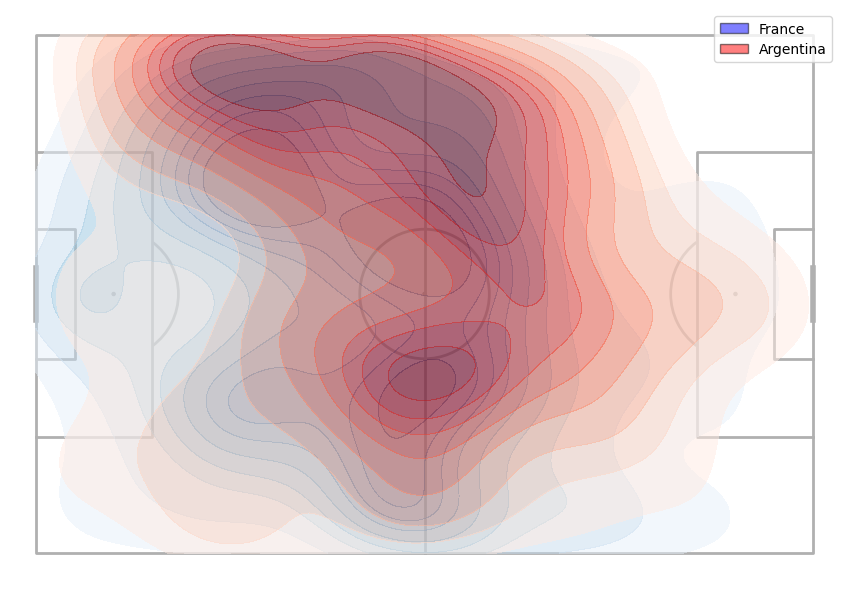

In [10]:
pitch = mpl.Pitch(pitch_type='statsbomb', pitch_length=PITCH_X, pitch_width=PITCH_Y)
fig, ax = pitch.draw(figsize=figsize)
k1 = pitch.kdeplot(france_x, france_y, cmap='Blues', fill=True, levels=10, alpha=0.5, ax=ax)
k2 = pitch.kdeplot(arg_x, arg_y, cmap='Reds', fill=True, levels=10, alpha=0.5, ax=ax)

add_legend(ax=ax, num_elements=2, colors=["blue", "red"], labels=["France", "Argentina"])


France seems to have dominated the midfield, and with a double pivot of N'Golo Kante and Paul Pogba, with the addition of Blaise Matuidi on the left, this reflects the density peaks in those positions.

Argentina on the other hand seems to have taken most of their actions on the right side. Looking at their starting lineup, this isn't immediately clear, but we can investigate this by looking at the players and the actions they have taken. Inspired by [this post](https://karun.in/blog/interactive-passing-networks.html) by Karun Singh, let us plot the average positions of the players of the starting 11.

In [11]:
france_avg_pos = events_handler.compute_avg_pos_for_starting_xi(team_name1)
argentina_avg_pos = events_handler.compute_avg_pos_for_starting_xi(team_name2)

In [12]:
starting_xi = events_handler.get_starting_xi_from_events_df()

In [13]:
france_avg_pos_with_starting_xi = france_avg_pos.join(starting_xi, on="player_id", how="left")
argentina_avg_pos_with_starting_xi = argentina_avg_pos.join(starting_xi, on="player_id", how="left")

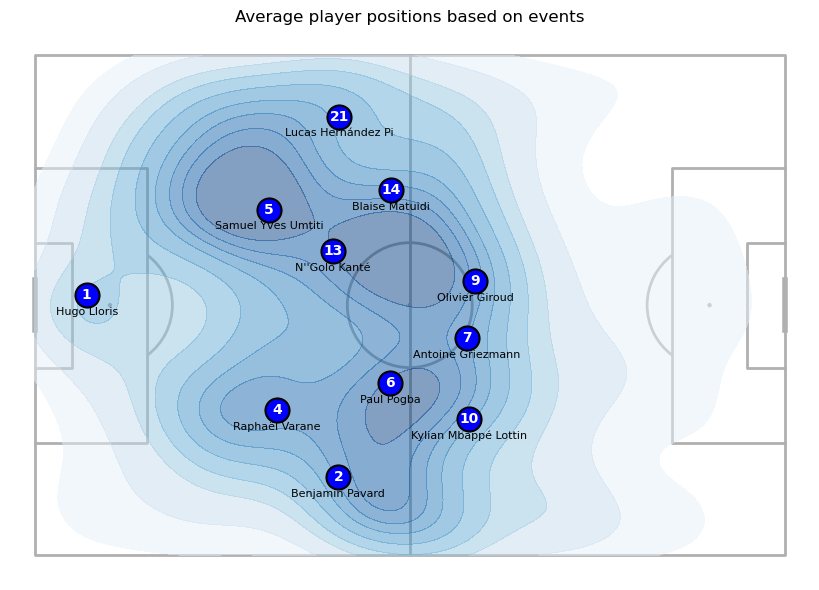

In [14]:
pitch = mpl.Pitch(pitch_type='statsbomb', pitch_length=PITCH_X, pitch_width=PITCH_Y)
fig, ax = pitch.draw(figsize=figsize)
k1 = pitch.kdeplot(france_x, france_y, cmap='Blues', fill=True, levels=10, alpha=0.5, ax=ax)

x, y = france_avg_pos_with_starting_xi["avg_x"].to_numpy(), france_avg_pos_with_starting_xi["avg_y"].to_numpy()
jerseys = france_avg_pos_with_starting_xi["jersey_number"].to_list()
names = france_avg_pos_with_starting_xi["player_name"].to_list()

plot_player_positions(x=x, y=y, jerseys=jerseys, names=names, pitch=pitch, ax=ax, color='blue', fontsize=12, alpha=0.7, offset=10)


We indeed see that Blaise Matuidi has dropped inwards from the wing and tucks into the left side of the midfield, forming a three-man midfield with Kante and Pogba. Even though their starting lineup is a 4-2-3-1 on paper, the data shows that they are mainly lining up in a 4-3-3. Now let us do the same for Argentina.

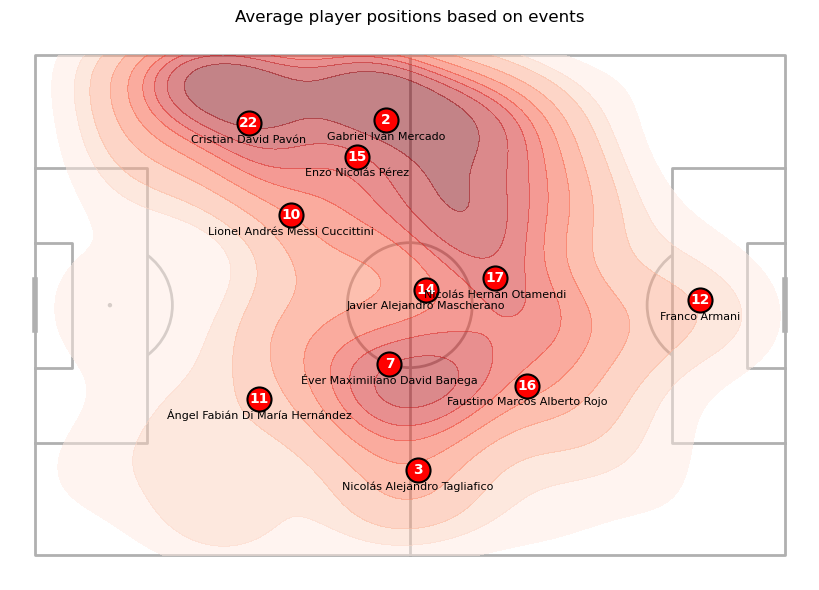

In [15]:
pitch = mpl.Pitch(pitch_type='statsbomb', pitch_length=PITCH_X, pitch_width=PITCH_Y)
fig, ax = pitch.draw(figsize=figsize)
k2 = pitch.kdeplot(arg_x, arg_y, cmap='Reds', fill=True, levels=10, alpha=0.5, ax=ax)

x, y = argentina_avg_pos_with_starting_xi["avg_x"].to_numpy(), argentina_avg_pos_with_starting_xi["avg_y"].to_numpy()
x_inverted = invert_one_orientation(x, PITCH_X)  # Invert x-coordinates for Argentina
y_inverted = invert_one_orientation(y, PITCH_Y)  # Invert y-coordinates for Argentina
jerseys = argentina_avg_pos_with_starting_xi["jersey_number"].to_list()
names = argentina_avg_pos_with_starting_xi["player_name"].to_list()
plot_player_positions(x=x_inverted, y=y_inverted, jerseys=jerseys, names=names, pitch=pitch, ax=ax, color='red', fontsize=12, alpha=0.7, offset=10)

Wow! The data clearly shows that Argentina has overloaded the right side, pushing up Pavon, Perez and Mercado into the same space. Even though they line up in a 4-3-3, their average positions resemble something like a 2-4-4 formation. Very unusual!

# Goals and expected goals (xG)
The game between France and Argentina ended 4-3. Despite Argentina outshooting France with 10 shots to 9, both with 4 on target, France managed to convert their chances better. To visualise this, we plot the location of all shots as well as all goals. 

In [16]:
france_shots = france_events.filter(pl.col("type") == "Shot")
france_shots_handler = ShotsHandler(france_shots)

france_shots_x, france_shots_y = france_shots_handler.compute_shot_x_y_locations()
france_goal_x, france_goal_y = france_shots_handler.compute_goal_x_y_locations()
france_shots_xg = france_shots_handler.compute_xg_from_goal_events()

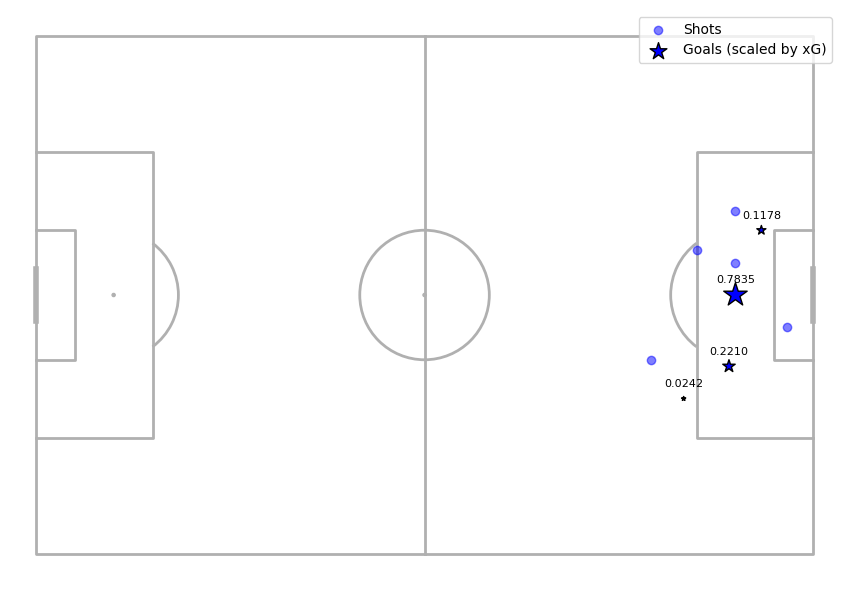

In [17]:
pitch = mpl.Pitch(pitch_type='statsbomb', pitch_length=PITCH_X, pitch_width=PITCH_Y)
fig, ax = pitch.draw(figsize=figsize)

plot_pitch_with_shots(ax, france_shots_x, france_shots_y, france_goal_x, france_goal_y, france_shots_xg, xg_scale_factor, color='blue')

We observe that the majority of France's shots are taken within the penalty box. This suggests their play style against Argentina put their attackers into favourable positions with favourable shooting positions. 

One of the shots taken outside the box was Pavard's half volley with an xG of just 0.0242 based on StatBomb's computations (This is a goal we will dive deeper into in the next part of the analysis). In contrast, another goal has an enormous xG of 0.7835, meaning a conversion rate of almost 78% from this position. If you haven't figured it out already, this is the penalty taken by Mbappe. When you compare it to the two other goals with more modest xG values of 0.1178 and 0.2210, it clearly highlights the just how decisive and high-quality a penalty kick can be.

Now we plot the same for Argentina.

In [18]:
argentina_shots = arg_events.filter(pl.col("type") == "Shot")
argentina_shots_handler = ShotsHandler(argentina_shots)
argentina_shots_x, argentina_shots_y = invert_orientation(*argentina_shots_handler.compute_shot_x_y_locations(), PITCH_X, PITCH_Y)
argentina_goal_x, argentina_goal_y = invert_orientation(*argentina_shots_handler.compute_goal_x_y_locations(), PITCH_X, PITCH_Y)
argentina_shots_xg = argentina_shots_handler.compute_xg_from_goal_events()

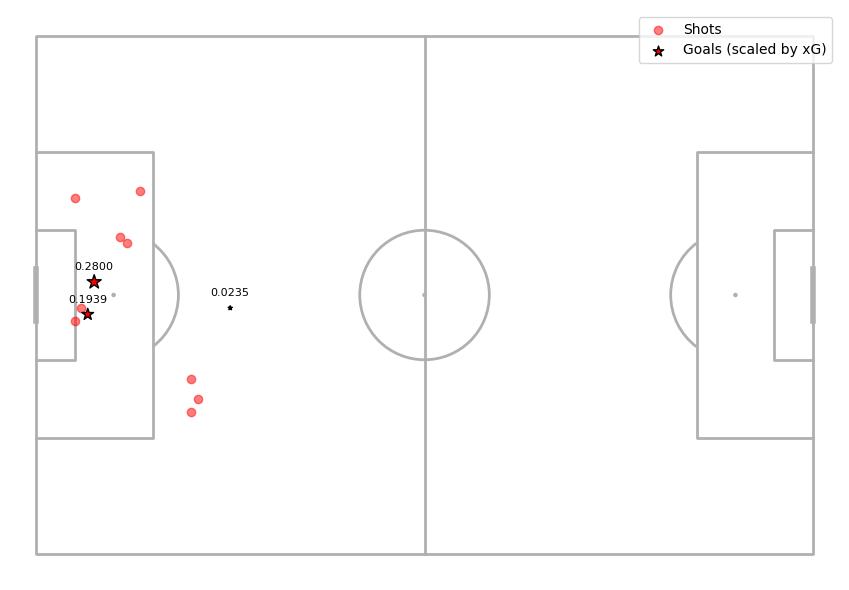

In [19]:
pitch = mpl.Pitch(pitch_type='statsbomb', pitch_length=PITCH_X, pitch_width=PITCH_Y)
fig, ax = pitch.draw(figsize=figsize)

plot_pitch_with_shots(ax, argentina_shots_x, argentina_shots_y, argentina_goal_x, argentina_goal_y, argentina_shots_xg, xg_scale_factor, color='red')

Interestingly, Argentina shoots more often from outside the box, particularly from the left where Di Maria is placed in the attack. They also has a outside-the-box goal with a similarly low xG value. 

# Possession patterns
Non-linear relationships in football are everywhere because the game is dynamic, and constrained by spatial and tactical rules. To analyse possession patterns and tactics of France and Argentina, we turn our heads to Gaussian mixture models (GMM) due to their ability to capture the underlying structure in complex, multi-dimensional data.

As the name suggests, Gaussian mixture models are constructed by using a mixture of Gaussian distributions, each weighted with a mixture weight $\pi_k$:
$$
p(\bf{x}) = \sum_{k=1}^K \pi_k \, \mathcal{N}(\bf{x} | \bf{\mu}_k, \bf{\Sigma}_k)
$$
where $K$ is the number of mixture elements determined from data.

We fit a GMM for both France and Argentina using possession data. We define this as events featuring carries, passes and successful dribbles.

The number of components is determined using the Bayesian Information Criterion (BIC):
$$
\text{BIC} = k \ln (n) - 2 \ln{(\hat{L})}
$$
where $\hat{L} = \max p(\mathbf{x} | \theta)$ is the maximised value of the likelihood function with parameters $\mathbf{\theta} = \{\mathbf{\pi}, \mathbf{\mu}, \mathbf{\Sigma}\}$, and $k$ is the number of mixture components.

In [30]:
france_gmm_handler = GMMHandler(france_events, invert_coords=False)
argentina_gmm_handler = GMMHandler(arg_events, invert_coords=True) 

france_possesion_events = france_gmm_handler.get_possession_events()
argentina_possesion_events = argentina_gmm_handler.get_possession_events()

In [31]:
france_gmm = france_gmm_handler.fit_gmm(france_possesion_events)

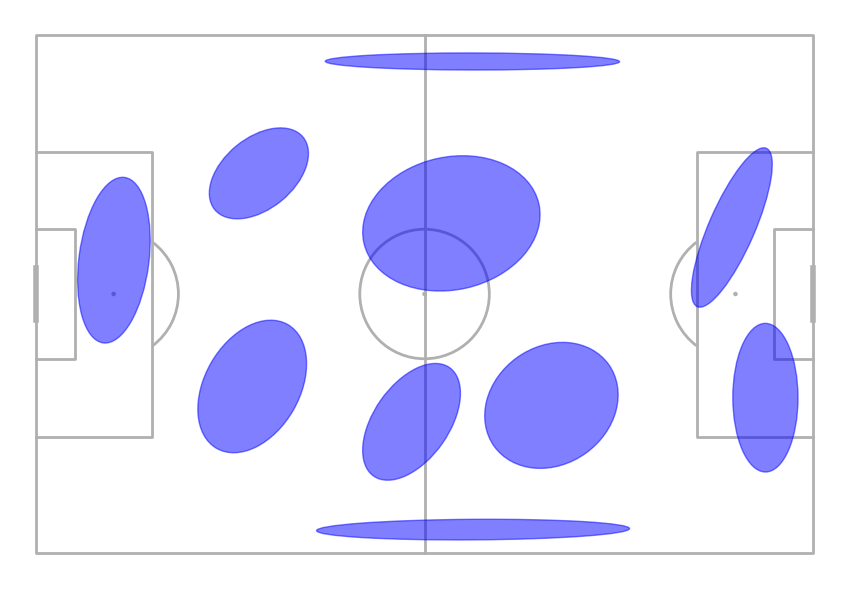

In [32]:
pitch = mpl.Pitch()
fig, ax = pitch.draw(figsize=figsize)
plot_gmm_components(france_gmm, ax, color='blue')

Using BIC, we get 10 components for our GMM. On the figure above, we have visualised the shape and size of each Gaussian component projected down onto a 2D pitch. We can immediately observe that there are two very distinct clusters in the fullback positions on either side of the pitch. This suggests that much of France's possession goes through the wing. Furthermore, there are two prominent clusters in the midfield, coinciding with the average positions of Kante, Matuidi, and Pogba.

Notice the cluster in France's goal keeping area and centreback positions. This suggests build up play from the back. In the modern game, it is no longer enough to just let the goalkeeper hoof the ball from the penalty box and hope an outfield player gets the ball. 

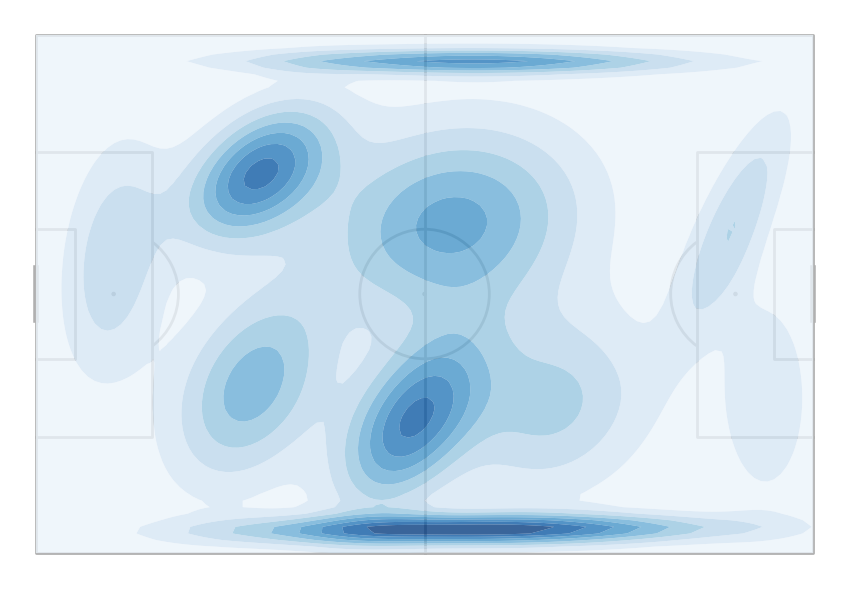

In [24]:
pitch = mpl.Pitch()
fig, ax = pitch.draw(figsize=figsize)
evaluate_and_plot_gmm_pdf(ax, france_gmm, PITCH_X, PITCH_Y, cmap='Blues')

We evaluate the PDF of the GMM and get the figure below. The probability densities of our GMM supports our previous observations: much of the possession comes through on the wings and centre of the midfield. Interestingly, much possession is also attributed to the area of the left centreback Umtiti.

In [33]:
argentina_gmm = argentina_gmm_handler.fit_gmm(argentina_possesion_events)

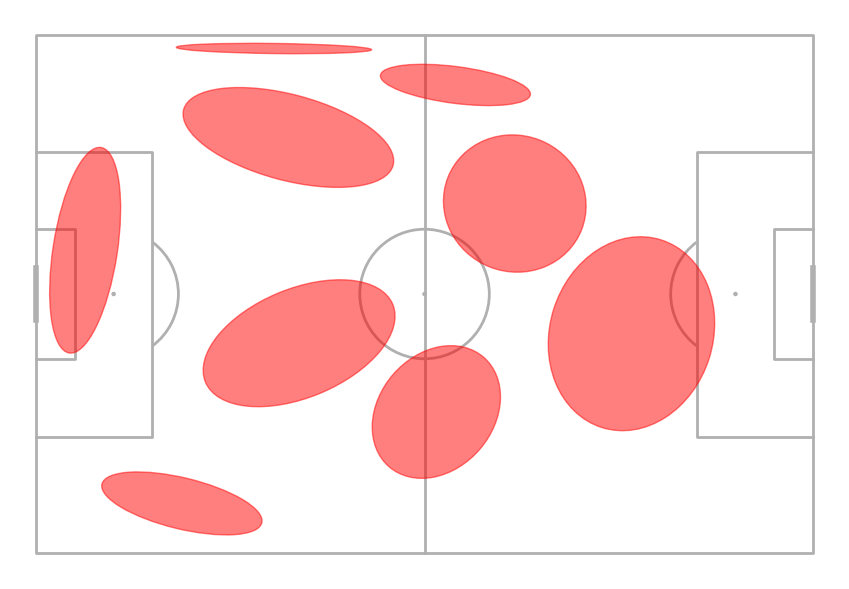

In [34]:
pitch = mpl.Pitch()
fig, ax = pitch.draw(figsize=figsize)
plot_gmm_components(argentina_gmm, ax, color='red')

In Argentina's case, the possession is heavily right-skewed. Much of the possession goes throug the right wing, where we previously saw an overload of four players, including Messi. Argentina interestingly also has a tendency to play out from the back. 

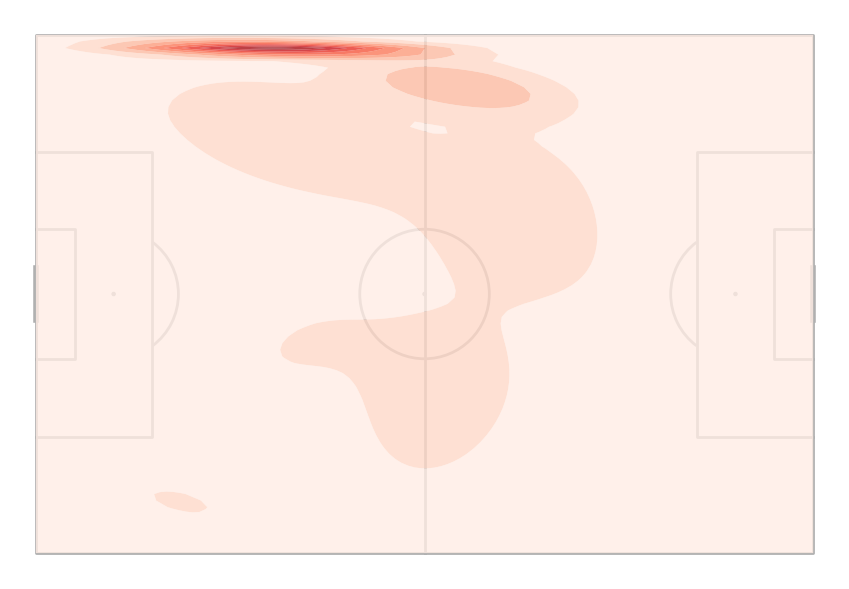

In [27]:
pitch = mpl.Pitch()
fig, ax = pitch.draw(figsize=figsize)
evaluate_and_plot_gmm_pdf(ax, argentina_gmm, PITCH_X, PITCH_Y, cmap='Reds')

Argentina's density shows that much of their possession happens on the right wing. This makes sense given the overload they have put on the right during the match.

# Sampling possession events from GMM
One of the neat features of using GMM instead of simple kernel densities is that we can sample from our fitted GMM model. In this case, we can sample possession events to analyse where France's next events *could* happen given their possession pattern in the match. 

This could be useful for opposing football analysts to understand how France plays and keeps posssession.

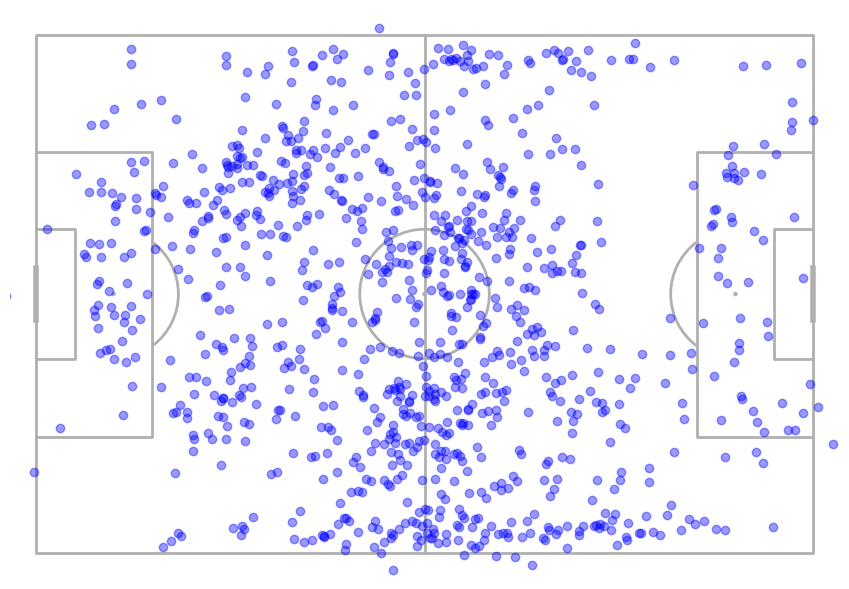

In [ ]:
france_samples, _ = france_gmm.sample(1000)

pitch = mpl.Pitch()
fig, ax = pitch.draw(figsize=figsize)
s = pitch.scatter(*france_samples.T, alpha=0.4, color='blue', ax=ax)

Now we do the same for Argentina.

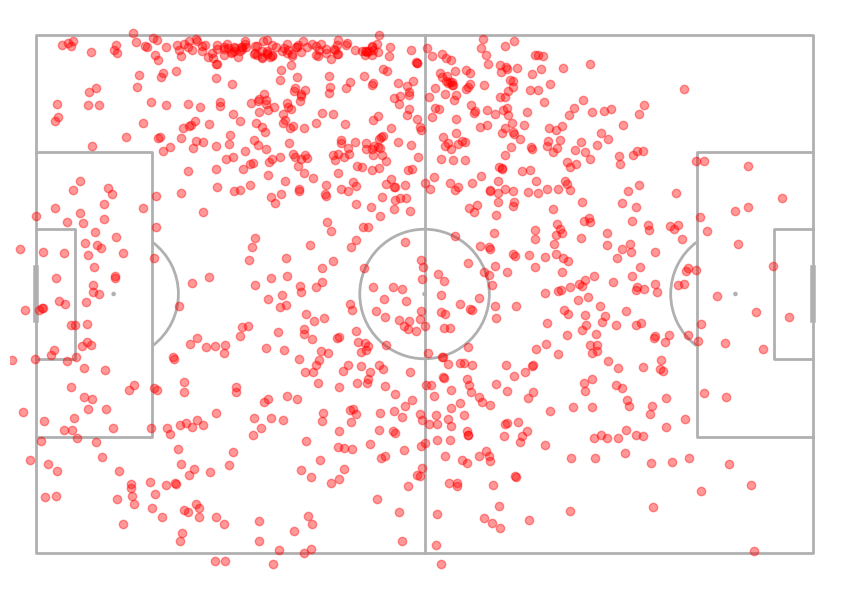

In [51]:
argentina_samples, _ = argentina_gmm.sample(1000) # we don't need to invert here since we already inverted when fitting the GMM

pitch = mpl.Pitch()
fig, ax = pitch.draw(figsize=figsize)
s = pitch.scatter(*argentina_samples.T, alpha=0.4, color='red', ax=ax)

Pretty cool!